In [1]:
# Install necessary libraries
import numpy as np
import pandas as pd
import os
import IPython.display as ipd
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
%matplotlib inline

Data can be downloaded from https://zenodo.org/record/3384388#.YG4jT68zbIU

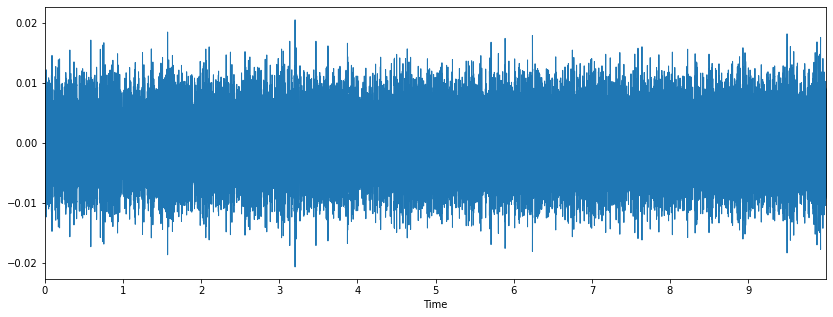

In [2]:
# audio data visualisation
audio_file_path = 'test_fan\\test_fan_abnormal_1.wav'
plt.figure(figsize=(14,5))
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)
librosa.display.waveplot(librosa_audio_data,sr=librosa_sample_rate)
ipd.Audio(audio_file_path)

In [3]:
# sample rate
librosa_sample_rate

22050

In [4]:
# mfcc feature
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 431)


In [5]:
def features_extractor(audio_file_path):
    """
    Extracts mfcc feature from audio
    """
    audio, sample_rate = librosa.load(audio_file_path, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)  
    return mfccs_scaled_features

def get_features(directory,label):
    """
    Extracts mfcc features of all audio files in a directory
    """
    audio_features_list = []
    for file_path in os.listdir(directory):
        print(file_path)
        audio_features_list.append([features_extractor(os.path.join(directory,file_path)),label])
    return audio_features_list

In [6]:
# Create list of mfcc feature of all audio files
top_dir_path = 'fan'
audio_feature_list = []
for dirid in os.listdir(top_dir_path):
    for type_of_sound in os.listdir(os.path.join(top_dir_path,dirid)):
        if type_of_sound == 'normal':
            audio_feature_list.extend(get_features(os.path.join(top_dir_path,dirid,type_of_sound),0))
        elif type_of_sound == 'abnormal':
            audio_feature_list.extend(get_features(os.path.join(top_dir_path,dirid,type_of_sound),1))

00000000.wav
00000001.wav
00000002.wav
00000003.wav
00000004.wav
00000005.wav
00000006.wav
00000007.wav
00000008.wav
00000009.wav
00000010.wav
00000011.wav
00000012.wav
00000013.wav
00000014.wav
00000015.wav
00000016.wav
00000017.wav
00000018.wav
00000019.wav
00000020.wav
00000021.wav
00000022.wav
00000023.wav
00000024.wav
00000025.wav
00000026.wav
00000027.wav
00000028.wav
00000029.wav
00000030.wav
00000031.wav
00000032.wav
00000033.wav
00000034.wav
00000035.wav
00000036.wav
00000037.wav
00000038.wav
00000039.wav
00000040.wav
00000041.wav
00000042.wav
00000043.wav
00000044.wav
00000045.wav
00000046.wav
00000047.wav
00000048.wav
00000049.wav
00000050.wav
00000051.wav
00000052.wav
00000053.wav
00000054.wav
00000055.wav
00000056.wav
00000057.wav
00000058.wav
00000059.wav
00000060.wav
00000061.wav
00000062.wav
00000063.wav
00000064.wav
00000065.wav
00000066.wav
00000067.wav
00000068.wav
00000069.wav
00000070.wav
00000071.wav
00000072.wav
00000073.wav
00000074.wav
00000075.wav
00000076.wav

In [7]:
len(audio_feature_list)

5550

In [8]:
# Create dataframe
df = pd.DataFrame(audio_feature_list,columns=['audio_feature','label'])
df['label'].value_counts()

0    4075
1    1475
Name: label, dtype: int64

In [9]:
# Handle imbalanced data 
df = df.groupby(by='label').sample(1475)
df['label'].value_counts()

1    1475
0    1475
Name: label, dtype: int64

In [10]:
X = np.array(df['audio_feature'].tolist())

In [11]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,df['label'],test_size=0.2,random_state=0)

In [12]:
# Hyperparameter tuning
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='Detect faulty fan')

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [14]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 16s]
val_accuracy: 0.5559322039286295

Best val_accuracy So Far: 0.9655367334683737
Total elapsed time: 00h 00m 56s
INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

Results summary
Results in my_dir\Detect faulty fan
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 416
units_1: 384
learning_rate: 0.0001
units_2: 32
units_3: 480
units_4: 512
units_5: 256
units_6: 96
units_7: 224
Score: 0.9655367334683737
Trial summary
Hyperparameters:
num_layers: 8
units_0: 96
units_1: 288
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
Score: 0.9468926588694254
Trial summary
Hyperparameters:
num_layers: 4
units_0: 64
units_1: 320
learning_rate: 0.0001
units_2: 160
units_3: 384
units_4: 352
units_5: 288
units_6: 96
units_7: 256
Score: 0.8841807842254639
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 64
learning_rate: 0.01
units_2: 448
units_3: 256
units_4: 256
units_5: 512
units_6: 480
units_7: 480
units_8: 320
units_9: 288
units_10: 384
units_11: 128
units_12: 96
units_13: 64
units_14: 512
units_15: 32
Score: 0.55593220392862

In [26]:
# Train on best model
best_model = tuner.get_best_models()[0]
best_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
74/74 [==============================] - 1s 6ms/step - loss: 0.2992 - accuracy: 0.8690 - val_loss: 0.1958 - val_accuracy: 0.9695
Epoch 2/20
74/74 [==============================] - 0s 3ms/step - loss: 0.2028 - accuracy: 0.9583 - val_loss: 0.1904 - val_accuracy: 0.9441
Epoch 3/20
74/74 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.9461 - val_loss: 0.1555 - val_accuracy: 0.9576
Epoch 4/20
74/74 [==============================] - 0s 4ms/step - loss: 0.1777 - accuracy: 0.9477 - val_loss: 0.1292 - val_accuracy: 0.9746
Epoch 5/20
74/74 [==============================] - 0s 3ms/step - loss: 0.1415 - accuracy: 0.9722 - val_loss: 0.1074 - val_accuracy: 0.9881
Epoch 6/20
74/74 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.9717 - val_loss: 0.1012 - val_accuracy: 0.9864
Epoch 7/20
74/74 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 0.9759 - val_loss: 0.0872 - val_accuracy: 0.9831
Epoch 8/20
74/74 [==

In [27]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 416)               17056     
_________________________________________________________________
dense_1 (Dense)              (None, 384)               160128    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                12320     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 189,537
Trainable params: 189,537
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Evaluation on test data
best_model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 1ms/step - loss: 0.0354 - accuracy: 0.9966


[0.0353630855679512, 0.996610164642334]

In [29]:
# Prediction on some sample
print(best_model.predict_classes(features_extractor('test_fan\\test_fan_abnormal_1.wav').reshape(1,40))[0][0])
print(best_model.predict_classes(features_extractor('test_fan\\test_fan_abnormal_2.wav').reshape(1,40))[0][0])
print(best_model.predict_classes(features_extractor('test_fan\\test_fan_abnormal_3.wav').reshape(1,40))[0][0])
print(best_model.predict_classes(features_extractor('test_fan\\test_fan_normal_1.wav').reshape(1,40))[0][0])
print(best_model.predict_classes(features_extractor('test_fan\\test_fan_normal_2.wav').reshape(1,40))[0][0])

1
1
1
0
0
